In [3]:
from discretizer import discretizer
from client import client
import torch
device = torch.device("cpu")
import matplotlib.pyplot as plt
from server import server_twosample_U


In [1]:
def generate_nearly_unif(alphabet_size, beta, sample_size):
  p = torch.arange(1,alphabet_size+1).pow(-beta)
  p = p.divide(p.sum())
  return(torch.multinomial(p, sample_size, replacement=True))

In [19]:
server_now = server_twosample_U(device)
alphabet_size = 10
beta = 0.5
privacy_level = 10
n_test = 100
significance_level = 0.05
test_result = torch.zeros(n_test)
for i in range(n_test):
    data_y = generate_nearly_unif(alphabet_size, beta, sample_size = 1000)
    data_z = generate_nearly_unif(alphabet_size, beta, sample_size = 1000)
    LDPclient = client(device)
    LDPclient.load_data_disc(data_y, data_z, alphabet_size)
    data_y_priv, data_z_priv = LDPclient.release_LapU(privacy_level)
    test_result[i] = server_now.release_p_value(data_y_priv, data_z_priv, 500)

tensor([ 5.9619e-01, -6.9526e-01,  7.9841e-01,  6.3978e-01, -5.4115e-02,
        -7.1706e-01, -5.9042e-02, -1.4118e+00, -5.4540e-01, -1.7210e-01,
        -7.0555e-01,  2.1704e+00,  2.4530e-01,  1.0062e-02,  1.4355e-01,
        -1.4539e+00, -1.1564e-01, -7.2045e-01, -1.7391e+00, -2.2231e-02,
         4.4031e-01, -3.9942e-01, -8.2322e-01, -1.0259e+00, -7.1552e-01,
         1.0211e+00,  2.4704e+00,  9.8998e-01, -6.9526e-01,  1.7378e-01,
        -8.9072e-01,  3.8212e+00,  9.8695e-01,  9.4515e-01,  2.1426e+00,
        -1.4816e+00, -1.0261e+00, -2.1653e+00,  1.0533e-01,  5.6709e-01,
        -2.1967e-01, -5.7479e-01, -1.5404e+00, -1.0044e+00, -2.2123e+00,
         4.3542e-01, -3.3755e-03,  7.4583e-01,  2.6786e+00,  1.8406e+00,
        -6.3335e-02,  1.3516e+00, -9.5562e-01, -2.0104e+00, -1.0395e+00,
        -7.5653e-01, -8.6875e-03, -1.0314e+00,  1.3551e+00, -2.1283e+00,
         5.0656e-01, -7.9293e-01, -1.1917e+00, -2.0659e-01, -8.6245e-01,
        -1.6506e+00, -1.2378e+00,  3.7504e-01, -5.2

In [20]:
test_result

tensor([0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020,
        0.0020])

In [79]:
(test_result < 0.7).sum()/n_test 

tensor(0.6750)

# testing the discretizer

In [3]:
data_conti = torch.tensor([
    [0, 0, 0, 0],
    [0, 0, 0, 0.6],
    [0, 0, 0.6, 0],
    [0, 0, 0.6, 0.6],
    [0, 0.6, 0, 0],
    [0, 0.6, 0, 0.6],
    [0, 0.6, 0.6, 0],
    [0, 0.6, 0.6, 0.6],   
    [0.6, 0, 0, 0],
    [0.6, 0, 0, 0.6],
    [0.6, 0, 0.6, 0],
    [0.6, 0, 0.6, 0.6],
    [0.6, 0.6, 0, 0],
    [0.6, 0.6, 0, 0.6],
    [0.6, 0.6, 0.6, 0],
    [0.6, 0.6, 0.6, 0.6],
])
dsc = discretizer(device)
data_disc, n_category = dsc.transform(data_conti, 2)
data_disc

LDPclient = client(device)
LDPclient.load_data_disc(data_disc, data_disc, n_category)

# testing the LapU for discrete data

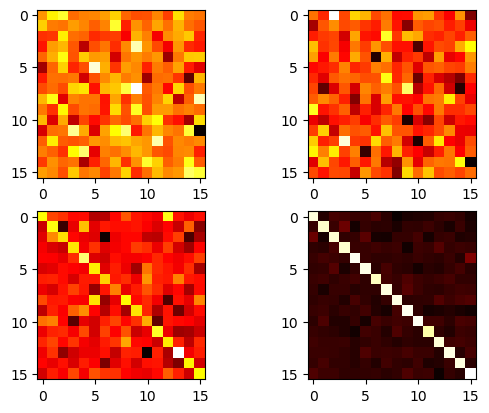

In [6]:
fig, axs = plt.subplots(2,2)
axs[0,0].imshow(LDPclient.release_LapU(0.5)[1], cmap = 'hot', interpolation = 'nearest')
axs[0,1].imshow(LDPclient.release_LapU(1)[1], cmap = 'hot', interpolation = 'nearest')
axs[1,0].imshow(LDPclient.release_LapU(10)[1], cmap = 'hot', interpolation = 'nearest')
axs[1,1].imshow(LDPclient.release_LapU(100)[1], cmap = 'hot', interpolation = 'nearest')

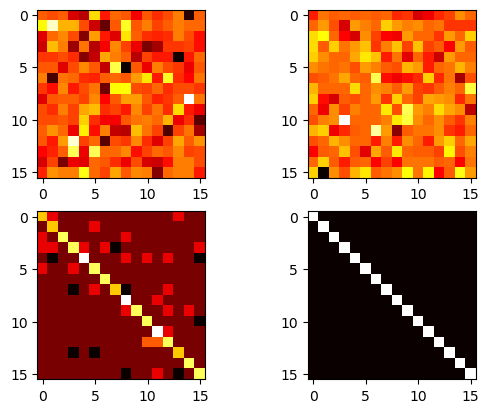

In [7]:
fig, axs = plt.subplots(2,2)
axs[0,0].imshow(LDPclient.release_DiscLapU(0.5)[1], cmap = 'hot', interpolation = 'nearest')
axs[0,1].imshow(LDPclient.release_DiscLapU(1)[1], cmap = 'hot', interpolation = 'nearest')
axs[1,0].imshow(LDPclient.release_DiscLapU(10)[1], cmap = 'hot', interpolation = 'nearest')
axs[1,1].imshow(LDPclient.release_DiscLapU(100)[1], cmap = 'hot', interpolation = 'nearest')

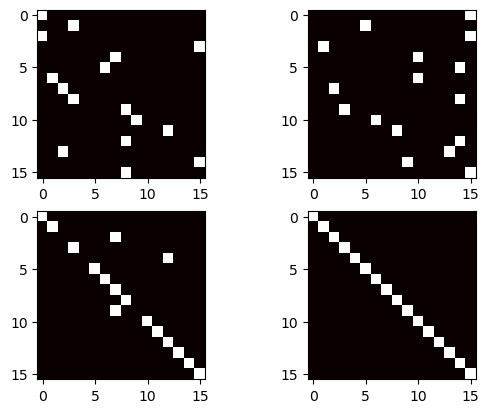

In [8]:
fig, axs = plt.subplots(2,2)
axs[0,0].imshow(LDPclient.release_genRR(0.5)[1], cmap = 'hot', interpolation = 'nearest')
axs[0,1].imshow(LDPclient.release_genRR(1)[1], cmap = 'hot', interpolation = 'nearest')
axs[1,0].imshow(LDPclient.release_genRR(5)[1], cmap = 'hot', interpolation = 'nearest')
axs[1,1].imshow(LDPclient.release_genRR(10)[1], cmap = 'hot', interpolation = 'nearest')

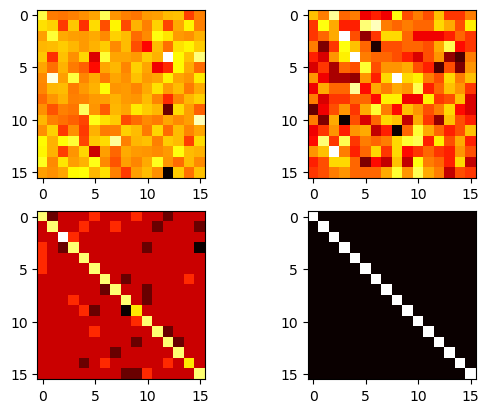

In [9]:
fig, axs = plt.subplots(2,2)
axs[0,0].imshow(LDPclient.release_DiscLapU(0.5)[1], cmap = 'hot', interpolation = 'nearest')
axs[0,1].imshow(LDPclient.release_DiscLapU(1)[1], cmap = 'hot', interpolation = 'nearest')
axs[1,0].imshow(LDPclient.release_DiscLapU(10)[1], cmap = 'hot', interpolation = 'nearest')
axs[1,1].imshow(LDPclient.release_DiscLapU(100)[1], cmap = 'hot', interpolation = 'nearest')



In [13]:
from abc import ABCMeta, abstractmethod
class server(client):
    def release_p_value(self, data_y, data_z, n_permutation):
        self._permutation_test(data_y, data_z, n_permutation)

    def _permutation_test(self, data_y, data_z, n_permutation):
        n_1 = self._get_sample_size(data_y)
        n_2 = self._get_sample_size(data_z) 
        n = n_1 + n_2
        tst_data_combined = torch.vstack((data_y, data_z))
       
        u_stat_original = self._calculate_statistic(data_y, data_z) #original statistic
        #print(f"original u-statistic:{u_stat_original}")
        
        #permutation procedure
        u_stat_permuted = torch.empty(n_permutation).to(self.cuda_device)
        
        for i in range(n_permutation):
            permutation = torch.randperm(n)
            perm_stat_now = self._calculate_statistic(
                tst_data_combined[permutation][:n_1,:],
                tst_data_combined[permutation][n_1:,:]
            ).to(self.cuda_device)
            u_stat_permuted[i] = perm_stat_now

               
        p_value_proxy = (1 +
                         torch.sum(
                             torch.gt(input = u_stat_permuted, other = u_stat_original)
                         )
                        ) / (n_permutation + 1)
      
        return(p_value_proxy)
    
    @abstractmethod   
    def _calculate_statistic(self, data_y, data_z):
        raise NotImplementedError()
    
def server_twosample_U(server):    
    def _calculate_statistic(self, data_y, data_z):
        n_1 = self._get_sample_size(data_y)
        n_2 = self._get_sample_size(data_z) 
    
        y_row_sum = torch.sum(data_y, axis = 0)
        z_row_sum = torch.sum(data_z, axis = 0)


        one_Phi_one = torch.inner(y_row_sum, y_row_sum)
        one_Psi_one = torch.inner(z_row_sum, z_row_sum)

        tr_Phi = torch.sum(torch.square(data_y))
        tr_Psi = torch.sum(torch.square(data_z))

        one_Phi_tilde_one = one_Phi_one - tr_Phi
        one_Psi_tilde_one = one_Psi_one - tr_Psi


        # y only part. log calculation in case of large n1
        sign_y = torch.sign(one_Phi_tilde_one)
        abs_u_y = torch.exp(torch.log(torch.abs(one_Phi_tilde_one)) - torch.log(n_1) - torch.log(n_1 - 1) )
        u_y = sign_y * abs_u_y


        # z only part. log calculation in case of large n2
        sign_z = torch.sign(one_Psi_tilde_one)

        abs_u_z = torch.exp(torch.log(torch.abs(one_Psi_tilde_one)) - torch.log(n_2) - torch.log(n_2 - 1) )
        u_z = sign_z * abs_u_z

        # cross part
        cross = torch.inner(y_row_sum, z_row_sum)
        sign_cross = torch.sign(cross)
        abs_cross = torch.exp(torch.log(torch.abs(cross)) +torch.log(torch.tensor(2))- torch.log(n_1) - torch.log(n_2) )
        u_cross = sign_cross * abs_cross

        return(u_y + u_z - u_cross)

tensor([0.1992, 0.1408, 0.1150, 0.0996, 0.0891, 0.0813, 0.0753, 0.0704, 0.0664,
        0.0630])
tensor([0.1992, 0.1408, 0.1150, 0.0996, 0.0891, 0.0813, 0.0753, 0.0704, 0.0664,
        0.0630])
